# 使用官方数据给的模型验证所有数据集

In [2]:
import numpy as np
import os
import keras
from sklearn import preprocessing
from tqdm import tqdm
import scipy.io as sio

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置gpu编号
eps = np.finfo(np.float).eps

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 读取模型及保存的音频数据
all_data = sio.loadmat('../data/stft.mat')  # 读取时数据还包含'__version__'等3个无关信息
model = keras.models.load_model('RNN_keras2.h5')
# load standardisation parameters
scaler = preprocessing.StandardScaler()
with np.load('scaler.npz') as data:
    scaler.mean_ = data['arr_0']
    scaler.scale_ = data['arr_1']

In [4]:
ori_labels = []
predict_labels = []
wav_num = 0
correct_num = 0

for wavfile in tqdm(all_data):  # wavfile是字典中音频的名字
    if wavfile[-3:] != "wav":
        continue

    X = all_data[wavfile]
    X = scaler.transform(X)   # apply standardization
    X = X[:model.input_shape[1], :]   # cut to input shape length (500 frames x 201 STFT bins)
    Theta = np.linalg.norm(X, axis=1) + eps  # apply normalization
    X /= np.mean(Theta)
    Xs = X[np.newaxis, ...]   # add sample dimension

    # predict output
    ys = model.predict(Xs, verbose=0)
    predict_label = np.argmax(ys, axis=1)[0]  # 数字, int型

    # 计数
    wav_num += 1
    label = wavfile[:wavfile.find('_')]  # 字符, '0','1','2',...,'10'
    if int(predict_label) == int(label):
        correct_num += 1
    ori_labels.append(int(label))
    predict_labels.append(predict_label)

# 统计最后结果
print("所有数据数目(5720):", wav_num)
print("使用官方模型测试所有音频识别准确率为:", correct_num / wav_num)

100%|██████████| 5723/5723 [1:04:10<00:00,  1.49it/s]

所有数据数目(5720): 5720
使用官方模型测试所有音频识别准确率为: 0.6667832167832168


In [5]:
from collections import defaultdict

res_class = defaultdict(list)  # 原标签分类统计
MAE_class = defaultdict(list)  # 计算每类的平均绝对误差

for idx, value in enumerate(ori_labels):
    res_class[value].append(predict_labels[idx])

for key in res_class:
    diff = [abs(val-key) for val in res_class[key]]
    MAE_class[key] = sum(diff) / len(diff)
print("MAE:", MAE_class)

MAE: defaultdict(<class 'list'>, {3: 0.20192307692307693, 8: 0.8461538461538461, 10: 0.38846153846153847, 1: 0.013461538461538462, 6: 0.5769230769230769, 9: 0.7557692307692307, 4: 0.39615384615384613, 2: 0.14423076923076922, 0: 0.0, 5: 0.25769230769230766, 7: 0.5230769230769231})


In [8]:
stft = [MAE_class[i] for i in range(11)]
stft

[0.0,
 0.013461538461538462,
 0.14423076923076922,
 0.20192307692307693,
 0.39615384615384613,
 0.25769230769230766,
 0.5769230769230769,
 0.5230769230769231,
 0.8461538461538461,
 0.7557692307692307,
 0.38846153846153847]

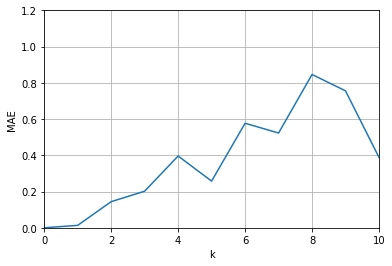

In [15]:
import matplotlib.pyplot as plt

plt.plot(stft)
plt.grid()
plt.xlabel('k')
plt.ylabel('MAE')
plt.xlim((0, 10))
plt.ylim((0, 1.2))
plt.show()